## Ford Gobike Data Exploration


In [217]:
#Importing required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

%matplotlib inline
pd.set_option("display.max_columns", None)


In [218]:
# Read csv files into a pandas dataframe
df = pd.read_csv("201902-fordgobike-tripdata.csv")
df_bike = df.copy()
df_bike.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [219]:
#check the dataset features types and shape
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   start_station_id         183215 non-null  float64
 4   start_station_name       183215 non-null  object 
 5   start_station_latitude   183412 non-null  float64
 6   start_station_longitude  183412 non-null  float64
 7   end_station_id           183215 non-null  float64
 8   end_station_name         183215 non-null  object 
 9   end_station_latitude     183412 non-null  float64
 10  end_station_longitude    183412 non-null  float64
 11  bike_id                  183412 non-null  int64  
 12  user_type                183412 non-null  object 
 13  member_birth_year        175147 non-null  float64
 14  memb

In [220]:
# Number of unique values in Features 
df_bike.nunique()

duration_sec                 4752
start_time                 183401
end_time                   183397
start_station_id              329
start_station_name            329
start_station_latitude        334
start_station_longitude       335
end_station_id                329
end_station_name              329
end_station_latitude          335
end_station_longitude         335
bike_id                      4646
user_type                       2
member_birth_year              75
member_gender                   3
bike_share_for_all_trip         2
dtype: int64

In [221]:
#descriptive statistics for dataset
df_bike.describe().round(2)

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.00,183215.00,183412.00,183412.00,183215.00,183412.00,183412.00,183412.00,175147.00
mean,726.08,138.59,37.77,-122.35,136.25,37.77,-122.35,4472.91,1984.81
std,1794.39,111.78,0.10,0.12,111.52,0.10,0.12,1664.38,10.12
min,61.00,3.00,37.32,-122.45,3.00,37.32,-122.45,11.00,1878.00
25%,325.00,47.00,37.77,-122.41,44.00,37.77,-122.41,3777.00,1980.00
50%,514.00,104.00,37.78,-122.40,100.00,37.78,-122.40,4958.00,1987.00
75%,796.00,239.00,37.80,-122.29,235.00,37.80,-122.29,5502.00,1992.00
max,85444.00,398.00,37.88,-121.87,398.00,37.88,-121.87,6645.00,2001.00


In [222]:
#Any duplicated rows ?
df_bike.duplicated().sum()

0

In [223]:
def CheckMissingValues(data_set):
    sum_of_null_values = data_set.isnull().sum().sum()
    # Total missing values for each feature
    if sum_of_null_values > 0:
        for columns in data_set:
            if data_set[columns].isnull().any():
                print('[{0}]: {1} null values , Percentage = {2:.2f}% '
                .format(columns, data_set[columns].isnull().sum(), 
                          (data_set[columns].isnull().sum() / len(data_set[columns])*100)))
    else : 
        print('No Missing Values') 
    
CheckMissingValues(df_bike)


[start_station_id]: 197 null values , Percentage = 0.11% 
[start_station_name]: 197 null values , Percentage = 0.11% 
[end_station_id]: 197 null values , Percentage = 0.11% 
[end_station_name]: 197 null values , Percentage = 0.11% 
[member_birth_year]: 8265 null values , Percentage = 4.51% 
[member_gender]: 8265 null values , Percentage = 4.51% 


In [224]:
#check if start_station_id , start_station_name , end_station_id and end_station_name have the same missing values 
x = df_bike[df_bike['start_station_name'].isnull()]
x.isnull().sum()

duration_sec                 0
start_time                   0
end_time                     0
start_station_id           197
start_station_name         197
start_station_latitude       0
start_station_longitude      0
end_station_id             197
end_station_name           197
end_station_latitude         0
end_station_longitude        0
bike_id                      0
user_type                    0
member_birth_year            2
member_gender                2
bike_share_for_all_trip      0
dtype: int64

In [225]:
def AddDistance(start_latitude, start_longitude, end_latitude, end_longitude):
    coords_1 = (start_latitude, start_longitude)
    coords_2 = (end_latitude, end_longitude)
    return geopy.distance.geodesic(coords_1, coords_2).km
#Add distance feature
df_bike['distance_km'] = df_bike.apply(lambda x: AddDistance(x['start_station_latitude'], x['start_station_longitude'],
                                                           x['end_station_latitude'], x['end_station_longitude']), axis=1)

In [226]:
#check the number of rows with distance = 0
x = df_bike[df_bike.distance_km == 0]
x.shape[0]

3880

In [227]:
#check the number of rows with age > 100
y = df_bike[df_bike['member_birth_year'] <= 1921]
y.shape[0]

75

In [228]:
#drop missing values in start_station_id , start_station_name , end_station_id and end_station_name
df_bike = df_bike.dropna(subset=['start_station_id' , 'start_station_name' , 'end_station_id' , 'end_station_name'])
# drop index with age > 100 years
df_bike = df_bike.drop(df_bike.index[df_bike['member_birth_year'] <= 1921])
# drop index with with distance = 0
df_bike = df_bike.drop(df_bike.index[df_bike.distance_km == 0])
# fill missing values in member_birth_year with mode()
df_bike['member_birth_year'] = df_bike['member_birth_year'].fillna(df_bike.member_birth_year.mode()[0])
# fill missing values in member_gender with "Unknown"
df_bike['member_gender'] = df_bike['member_gender'].fillna('Unknown')


In [229]:
#change type of time data from object to datetime to extract features
df_bike[['start_time' , 'end_time']] = df_bike[['start_time' , 'end_time']].apply(pd.to_datetime).values.astype('<M8[m]')
#get colums for start date , hour and day name from start_time column
df_bike['start_day'] = df_bike['start_time'].dt.day_name()
df_bike['start_time'] = pd.to_datetime(df_bike['start_time'], format='%H:%M' ,).dt.time
#get colums for end  date , hour and day namefrom end_time column
df_bike['end_day'] = df_bike['end_time'].dt.day_name()
df_bike['end_time'] = pd.to_datetime(df_bike['end_time'], format='%H:%M').dt.time

In [230]:
#start_station_id , end_station_id and bike_id to string
df_bike[['start_station_id' , 'end_station_id' , 'bike_id']] = df_bike[['start_station_id' , 'end_station_id' , 'bike_id']].astype('str')
#user_type  and member_gender to category
df_bike[['user_type','member_gender']] = df_bike[['user_type','member_gender']].astype('category')
#bike_share_for_all_trip to bool
df_bike['bike_share_for_all_trip'] = df_bike['bike_share_for_all_trip'].astype(bool)
#convert member_birth_year to ages
df_bike['member_age'] = (2021 - df_bike['member_birth_year']).astype('int')
#convert duration_sec to minutes
df_bike['duration_minute'] = (df_bike['duration_sec']/60).astype('int')

In [231]:
#drop columns which they are not useful at analysis
df_bike.drop(['start_station_latitude' , 'start_station_longitude' , 'member_birth_year',
              'end_station_latitude' , 'end_station_longitude' ,'duration_sec',], axis=1, inplace=True)


In [232]:
#check changes
df_bike.describe().round(2)

,distance_km,member_age,duration_minute
count,179318.00,179318.00,179318.00
mean,1.73,36.02,11.16
std,1.08,9.73,27.60
min,0.01,20.00,1.00
25%,0.94,29.00,5.00
50%,1.46,33.00,8.00
75%,2.26,40.00,13.00
max,69.47,94.00,1424.00


In [233]:
#check changes
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179318 entries, 0 to 183411
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   start_time               179318 non-null  object  
 1   end_time                 179318 non-null  object  
 2   start_station_id         179318 non-null  object  
 3   start_station_name       179318 non-null  object  
 4   end_station_id           179318 non-null  object  
 5   end_station_name         179318 non-null  object  
 6   bike_id                  179318 non-null  object  
 7   user_type                179318 non-null  category
 8   member_gender            179318 non-null  category
 9   bike_share_for_all_trip  179318 non-null  bool    
 10  distance_km              179318 non-null  float64 
 11  start_day                179318 non-null  object  
 12  end_day                  179318 non-null  object  
 13  member_age               179318 non-null  in

### What is the structure of your dataset?
dataset contains  183412 rows and 16 columns
after Wrangling and cleaning process  dataset contains  179318 rows and 15 columns

### What is/are the main feature(s) of interest in your dataset?
I'm most interested in what parameters affect trip duration
### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
I expect that the member_gender , member_age , user_type  , distance and start day and time  will help me at this analysis

## Univariate Exploration


- lets explore the individual variables which help us at our analysis

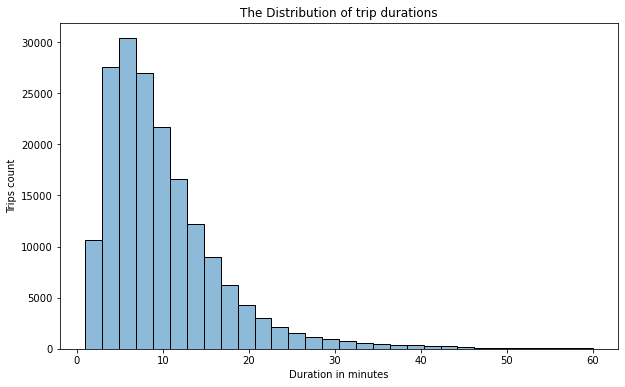

In [234]:
#the distribution of trip durations
x = df_bike[df_bike["duration_minute"]<= 60]
plt.figure(figsize = [10, 6])
sns.histplot(x.duration_minute , alpha= 0.5, bins =30 );
plt.xlabel("Duration in minutes")
plt.ylabel("Trips count")
plt.title("The Distribution of trip durations")
plt.show()

Short trips "less than 30 minutes" are the most common for users

In [235]:
#filter them to be easy to get analysis result 
df_bike = df_bike[df_bike.duration_minute <= 60]
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178030 entries, 4 to 183411
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   start_time               178030 non-null  object  
 1   end_time                 178030 non-null  object  
 2   start_station_id         178030 non-null  object  
 3   start_station_name       178030 non-null  object  
 4   end_station_id           178030 non-null  object  
 5   end_station_name         178030 non-null  object  
 6   bike_id                  178030 non-null  object  
 7   user_type                178030 non-null  category
 8   member_gender            178030 non-null  category
 9   bike_share_for_all_trip  178030 non-null  bool    
 10  distance_km              178030 non-null  float64 
 11  start_day                178030 non-null  object  
 12  end_day                  178030 non-null  object  
 13  member_age               178030 non-null  in

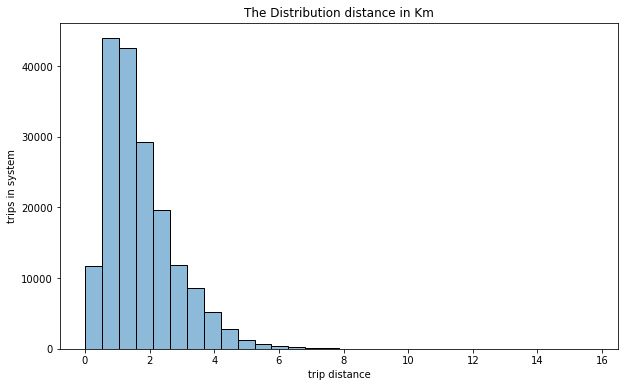

In [236]:
#the distribution of distance 
plt.figure(figsize = [10, 6])
sns.histplot( df_bike.distance_km, alpha= 0.5, bins =30 );
plt.xlabel("trip distance")
plt.ylabel("trips in system")
plt.title("The Distribution distance in Km")

plt.show()

- Short trips "less than 8 Km" are the most common for users

In [237]:
#filter them to be easy to get analysis result 
df_bike = df_bike[df_bike.distance_km <= 8]
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177973 entries, 4 to 183411
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   start_time               177973 non-null  object  
 1   end_time                 177973 non-null  object  
 2   start_station_id         177973 non-null  object  
 3   start_station_name       177973 non-null  object  
 4   end_station_id           177973 non-null  object  
 5   end_station_name         177973 non-null  object  
 6   bike_id                  177973 non-null  object  
 7   user_type                177973 non-null  category
 8   member_gender            177973 non-null  category
 9   bike_share_for_all_trip  177973 non-null  bool    
 10  distance_km              177973 non-null  float64 
 11  start_day                177973 non-null  object  
 12  end_day                  177973 non-null  object  
 13  member_age               177973 non-null  in

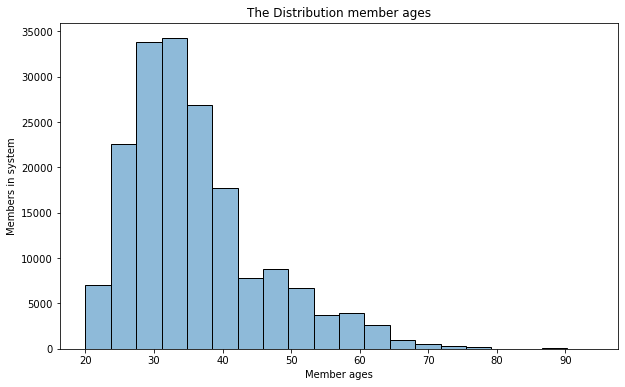

In [238]:
#the distribution of member_age 
plt.figure(figsize = [10, 6])
sns.histplot( df_bike.member_age, alpha= 0.5, bins =20 );
plt.xlabel("Member ages")
plt.ylabel("Members in system")
plt.title("The Distribution member ages")

plt.show()

In [239]:
#filter them to be easy to get analysis result 
df_bike = df_bike[df_bike.member_age <= 80]
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177847 entries, 4 to 183411
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   start_time               177847 non-null  object  
 1   end_time                 177847 non-null  object  
 2   start_station_id         177847 non-null  object  
 3   start_station_name       177847 non-null  object  
 4   end_station_id           177847 non-null  object  
 5   end_station_name         177847 non-null  object  
 6   bike_id                  177847 non-null  object  
 7   user_type                177847 non-null  category
 8   member_gender            177847 non-null  category
 9   bike_share_for_all_trip  177847 non-null  bool    
 10  distance_km              177847 non-null  float64 
 11  start_day                177847 non-null  object  
 12  end_day                  177847 non-null  object  
 13  member_age               177847 non-null  in

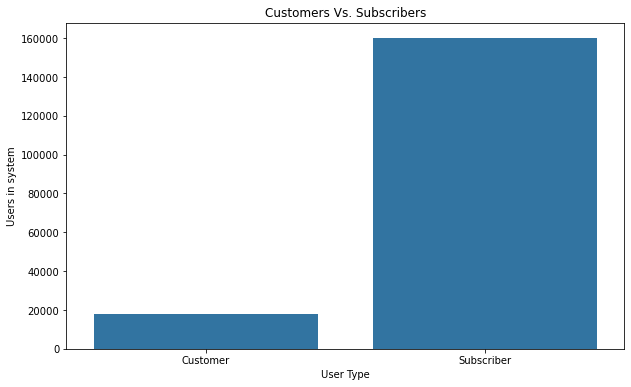

In [240]:
#the distribution of user_type 
plt.figure(figsize = [10, 6])
base_color= sns.color_palette()[0]
sns.countplot(data=df_bike, x='user_type',color=base_color);
plt.title("Customers Vs. Subscribers");
plt.ylabel("Users in system");
plt.xlabel("User Type");

- subscriber are the most common 

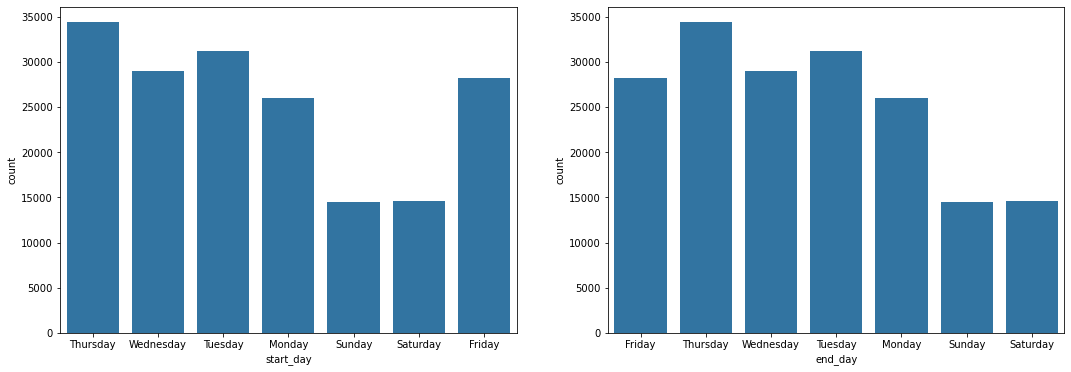

In [241]:
plt.figure(figsize = [18, 6])
plt.subplot(1, 2,1)
sns.countplot(data=df_bike, x=df_bike.start_day,color=base_color);
plt.subplot(1, 2, 2)
sns.countplot(data=df_bike, x=df_bike.end_day,color=base_color);


- the distribution of both are the most the same most of trips start and end at works days than holidays 

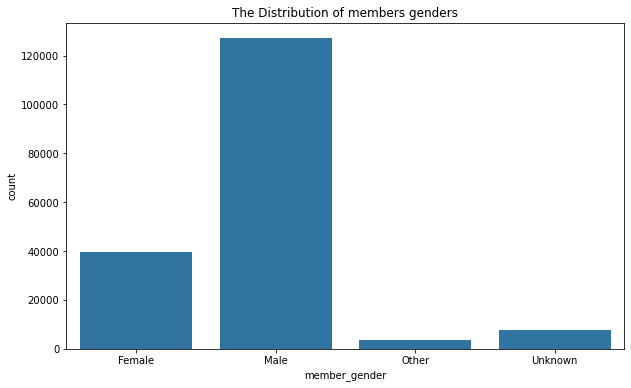

In [242]:
#the distribution of member_gender 
plt.figure(figsize = [10, 6])
sns.countplot(data=df_bike, x='member_gender',color=base_color);
plt.title("The Distribution of members genders");


- male are the most common

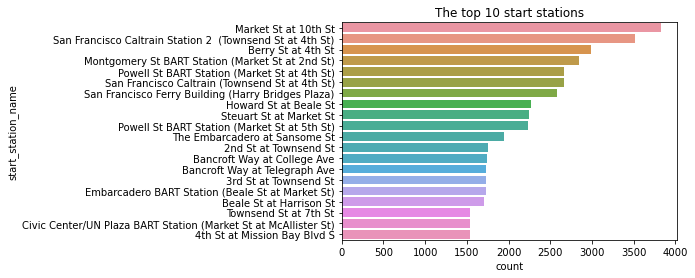

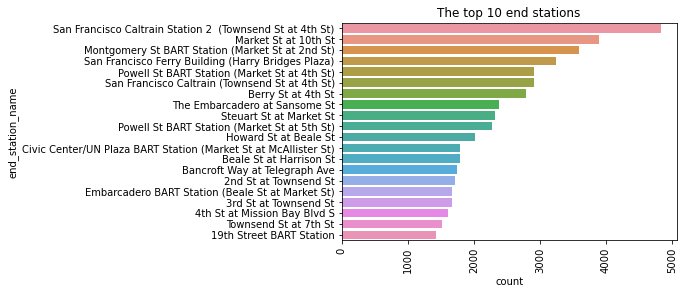

In [243]:
#the distribution of start station 
freq = df_bike['start_station_name'].value_counts()[0:20]
order = freq.index
sns.countplot(data=df_bike, y='start_station_name', order=order);
plt.title("The top 10 start stations");
plt.show()

#the distribution of end station
freq = df_bike['end_station_name'].value_counts()[0:20]
order = freq.index
sns.countplot(data=df_bike, y='end_station_name', order=order);
plt.xticks(rotation=90);
plt.title("The top 10 end stations");
plt.show()



-  the most hours have trips (start and end ) are between 8 am to 5pm

Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
- most of trips between 8 am and 5 pm
- most of trips are short between 5 and 15 minutes
- males are the most member gender
- range of members age between 25 and 40 are the most common
Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
- the duration of trips most of them are too short and some of them are like a day so I filter all these long trips to focuses on the most common trip long to be easy at analysis
- ages are have the same process 


### Bivariate Exploration
- I want to look at the pairwise correlations present between features in the data.


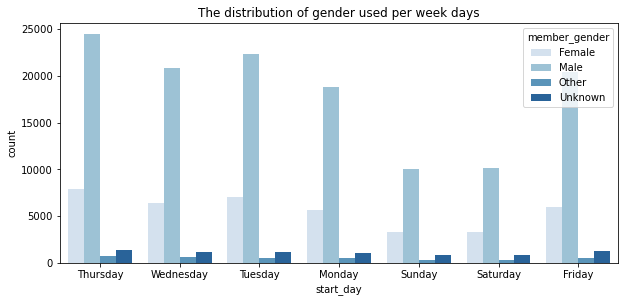

In [244]:

plt.figure(figsize = [10, 15])
plt.subplot(3, 1, 1)
sns.countplot(data = df_bike, x = 'start_day', hue = 'member_gender', palette = 'Blues');

plt.title("The distribution of gender used per week days");

plt.show()

- males are the most common used all weeks days

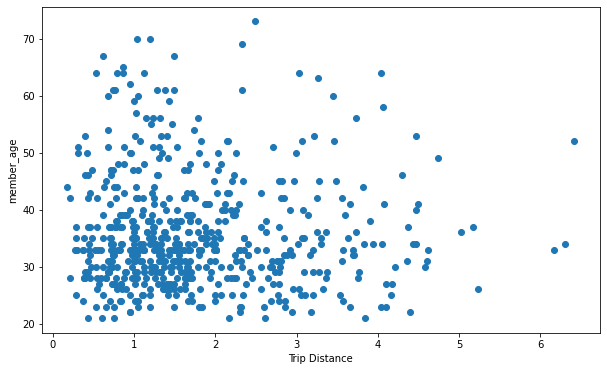

In [245]:
#corr of member age and  trip distance
plt.figure(figsize = [10, 6])
plt.scatter(x=df_bike['distance_km'].sample(600),y=df_bike['member_age'].sample(600));
plt.xlabel("Trip Distance");
plt.ylabel("member_age");

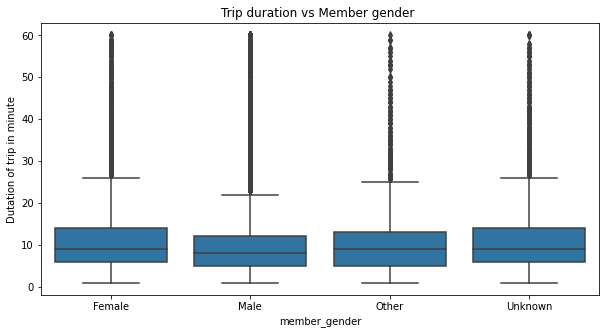

In [253]:
#distrbution of member gender and duration of trip
plt.figure(figsize = [10, 5])
sns.boxplot(data=df_bike, x='member_gender', y='duration_minute', color=base_color)
plt.xticks(rotation=0);
plt.ylabel('Dutation of trip in minute');
plt.title("Trip duration vs Member gender ");


- males have short trips than womans

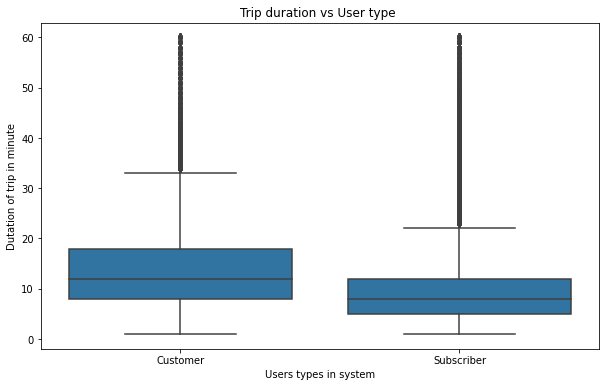

In [248]:
#distrbution of member gender and duration of trip
plt.figure(figsize=[10,6])
sns.boxplot(data=df_bike, x='user_type', y='duration_minute', color=base_color)
plt.ylabel('Dutation of trip in minute');
plt.xlabel('Users types in system');
plt.title("Trip duration vs User type ");


- more subscriber have short trips than customers

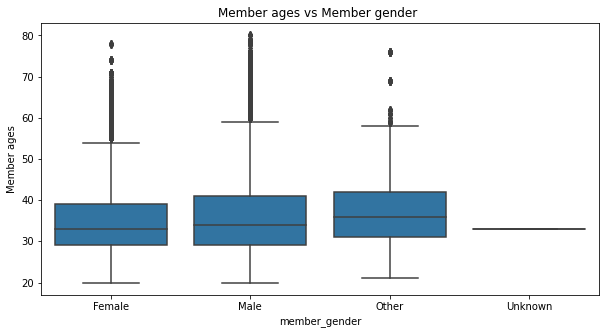

In [249]:
#distrbution of member gender and ages
plt.figure(figsize = [10, 5])
sns.boxplot(data=df_bike, x='member_gender', y='member_age', color=base_color)
plt.xticks(rotation=0);
plt.ylabel('Member ages');
plt.title("Member ages vs Member gender ");


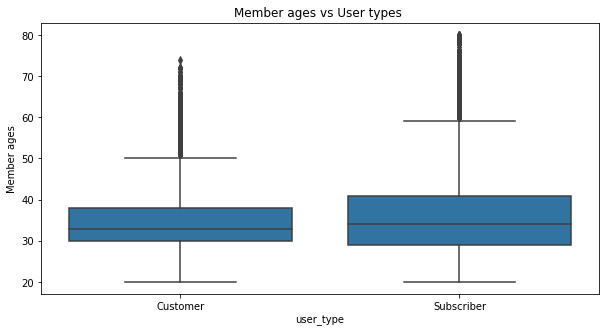

In [250]:
#distrbution of user_type and ages
plt.figure(figsize = [10, 5])
sns.boxplot(data=df_bike, x='user_type', y='member_age', color=base_color)
plt.xticks(rotation=0);
plt.ylabel('Member ages');
plt.title("Member ages vs User types ");


- here the types of users and their gender almost between 27 and 37 years old

Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
- as we see female have the most long trip duration in all genders 
- the customer users have long trips than subscribers
- and the range of customer and subscribers between 27 and 37 
so we can say the long trip depend of member age between 27 and 37 and be customer and female


Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
the member gender as we see the male are the most users all the week days but they don't have the long trips than females

### Multivariate Exploration
- explore more the 2 variables

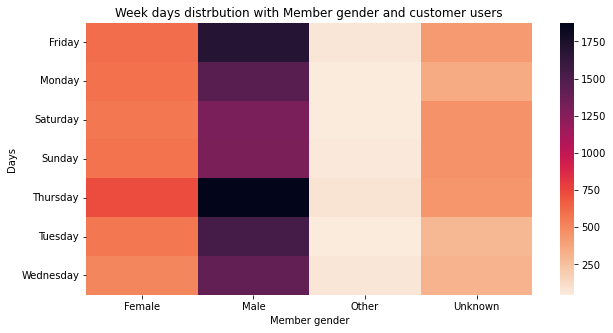

In [251]:
#Week days distrbution with Member gender and customer users
customers = df_bike.query('user_type == "Customer"')
ct_coun = customers.groupby(['start_day', 'member_gender']).size()
ct_coun = ct_coun.reset_index(name='count')
ct_coun = ct_coun.pivot(index='start_day', columns='member_gender', values='count')
plt.figure(figsize = [10, 5]);
sns.heatmap(ct_coun, cmap='rocket_r');
plt.xlabel('Member gender');
plt.ylabel('Days');
plt.title("Week days distrbution with Member gender and customer users");


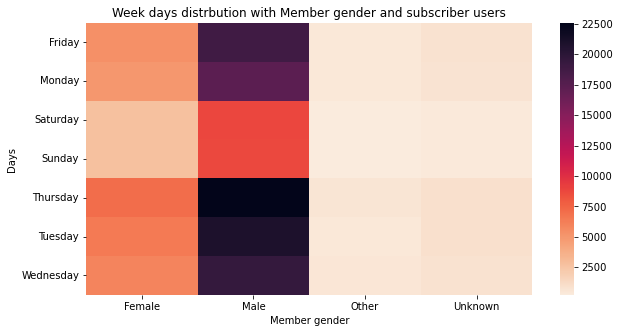

In [252]:
#Week days distrbution with Member gender and subscriber users
subscribers = df_bike.query('user_type == "Subscriber"')
st_coun = subscribers.groupby(['start_day', 'member_gender']).size()
st_coun = st_coun.reset_index(name='count')
st_coun = st_coun.pivot(index='start_day', columns='member_gender', values='count')
plt.figure(figsize = [10, 5]);
sns.heatmap(st_coun, cmap='rocket_r');
plt.title("Week days distrbution with Member gender and subscriber users");
plt.xlabel('Member gender');
plt.ylabel('Days');

Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?
- the Multivariate Exploration have confirmation our results in the last part and the relations between user type and the gender the trips


Were there any interesting or surprising interactions between features?
- most gender used and the trip duration